In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time
import math
from training import util

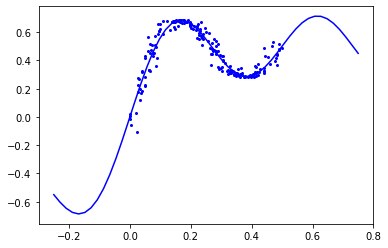

In [4]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

noise = 0.02 # 3, 0.02
#trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=noise, normalize=False, offset=50)
trainset = toy.TrigonometricToyDataset(sample_count=200, noise=noise, normalize=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

trainset.plot_dataset(extra_range=0.5)

Epoch 0: loss 0.7740780115127563
Epoch 10: loss 0.3980961740016937
Epoch 20: loss 0.007413177285343409
Epoch 30: loss -0.28294211626052856
Epoch 40: loss -0.3440382480621338
Epoch 50: loss -0.3348793685436249
Epoch 60: loss -0.3857370615005493
Epoch 70: loss -0.8273041248321533
Epoch 80: loss -1.1354459524154663
Epoch 90: loss -1.3645148277282715
torch.Size([50])


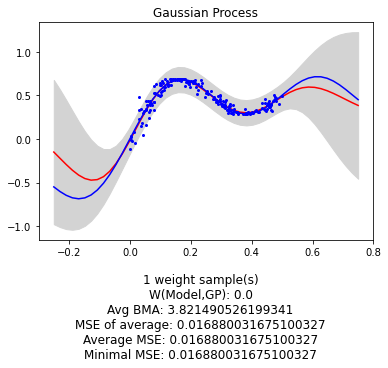

In [3]:
# Gaussian Process
import gpytorch

torch.manual_seed(42)

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, likelihood):
        super().__init__(trainset.normalized_xs, trainset.normalized_ys, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp = GPModel(likelihood)

gp.train()
likelihood.train()
optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

for epoch in range(100):
    optimizer.zero_grad()
    output = gp(trainset.normalized_xs)
    loss = -mll(output, trainset.normalized_ys)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")

def reference_gp(input):
    gp.eval()
    likelihood.eval()
    with torch.no_grad():
        dist = likelihood(gp(input.squeeze(-1)))
        return dist.mean, dist.variance

def eval_gp(input):
    return [reference_gp(input)]
trainset.plot("Gaussian Process", eval_gp, reference_gp, plot_sigma=True, extra_range=0.5)

Epoch 0: loss -0.4730733633041382
Epoch 100: loss -0.9044268727302551
Final loss -0.9154621958732605
torch.Size([50])


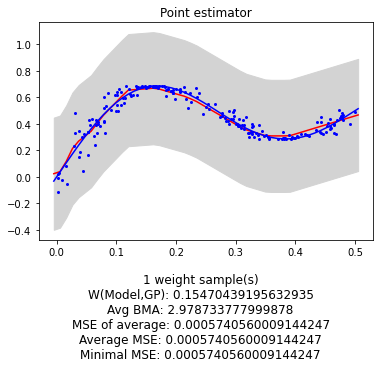

In [8]:
# Point estimator with L2 regularization
importlib.reload(util)

torch.manual_seed(42)

pp_model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 16), 
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.ReLU(),
    nn.Linear(16, 1)
), torch.tensor(noise), learn_var=False)

optimizer = torch.optim.SGD(pp_model.parameters(), lr=0.01)
for epoch in range(200):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = pp_model(data)
        loss = F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_pp(input):
    return [pp_model(input)]

trainset.plot("Point estimator", eval_pp, reference_gp, plot_sigma=True)

In [6]:
import experiments.toy_regression as exp

layers = [
    (1, 16),
    (16, 16),
    (16, 16),
    (16, 1)
]
learn_var = False

torch.manual_seed(42)
pp = exp.point_estimator(layers, torch.tensor(noise), learn_var, 500, trainloader, batch_size)

Epoch 0: loss -0.39127421379089355
Epoch 100: loss -0.6976404786109924
Epoch 200: loss -0.7924150824546814
Epoch 300: loss -0.7923218607902527
Epoch 400: loss -0.7978344559669495
Final loss -0.8017392158508301


torch.Size([50])


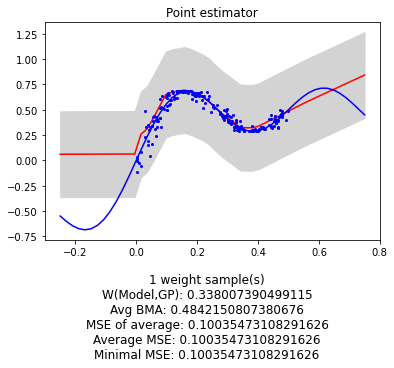

In [88]:
trainset.plot("Point estimator", eval_pp, reference_gp, plot_sigma=True, extra_range=0.5)

Epoch 0: loss -0.47309020161628723
Epoch 100: loss -0.8942028880119324
Epoch 200: loss -0.9263667464256287
Epoch 300: loss -0.9057298302650452
Epoch 400: loss -0.9122175574302673
Final loss -0.9145597815513611
torch.Size([50])


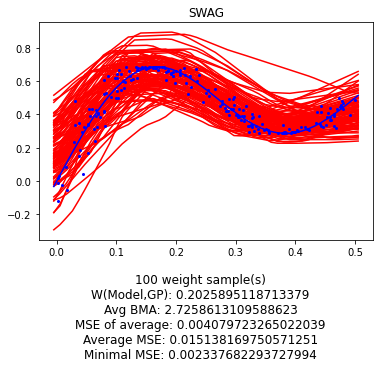

In [84]:
# SWAG trained with SGD and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

swag_model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 16), 
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.ReLU(),
    nn.Linear(16, 1)
), torch.tensor(noise))
optimizer = torch.optim.SGD(swag_model.parameters(), lr=0.01, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(swag_model, 5, 10)

for epoch in range(500):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = swag_model(data)
        loss = F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input):
    return [wrapper.sample(swag_model, input) for _ in range(100)]

trainset.plot("SWAG", eval_swag, reference_gp)

Training model 0
  Epoch 0: loss 103.316650390625
  Epoch 100: loss 2.7680869102478027
  Final loss 6.126331806182861
Training model 1
  Epoch 0: loss 98.11000061035156
  Epoch 100: loss 3.855863094329834
  Final loss 3.401787281036377
Training model 2
  Epoch 0: loss 96.33790588378906
  Epoch 100: loss 2.5617151260375977
  Final loss 2.132925510406494
Training model 3
  Epoch 0: loss 110.7802734375
  Epoch 100: loss 3.988790512084961
  Final loss 2.487733840942383
Training model 4
  Epoch 0: loss 112.5393295288086
  Epoch 100: loss 3.227149486541748
  Final loss 2.7807507514953613


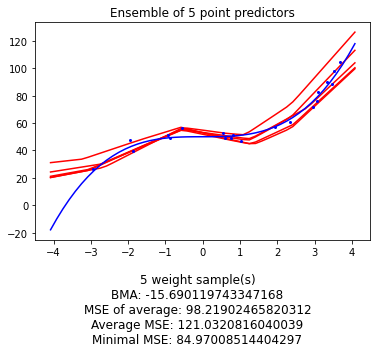

In [54]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

ensemble_count = 5
ensemble_model = [util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 16), 
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.ReLU(),
    nn.Linear(16, 16), 
    nn.ReLU(),
    nn.Linear(16, 1)
), torch.tensor(3)) for _ in range(ensemble_count)]

for i, model in enumerate(ensemble_model):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
    for epoch in range(500):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            mean, var = model(data)
            loss = F.gaussian_nll_loss(mean, target, var)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
        if epoch % 100 == 0:
            print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input):
     return [model(input) for model in ensemble_model]
trainset.plot(f"Ensemble of {ensemble_count} point predictors", eval_esemble)

Epoch 0: loss 89.34056854248047
Epoch 100: loss 8.38916301727295
Final loss 7.098074436187744


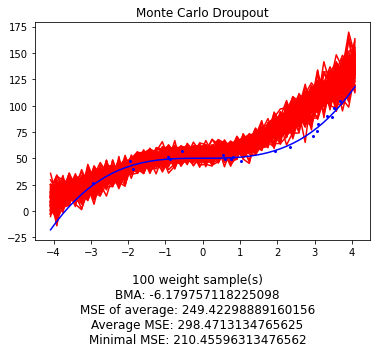

In [55]:
# MC dropout

torch.manual_seed(42)

p = 0.3

dropout_model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 150), 
    nn.ReLU(), 
    nn.Dropout(p),
    nn.Linear(150, 1),
), torch.tensor(3))

optimizer = torch.optim.SGD(dropout_model.parameters(), lr=0.01)
for epoch in range(160):
    dropout_model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = dropout_model(data)
        loss = F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_dropout(input):
    dropout_model.train() # Enable dropout
    return [dropout_model(input) for _ in range(100)]

trainset.plot("Monte Carlo Droupout", eval_dropout)

Epoch 0: loss 278.62176513671875
Epoch 100: loss 39.01836395263672
Final loss 40.86431121826172


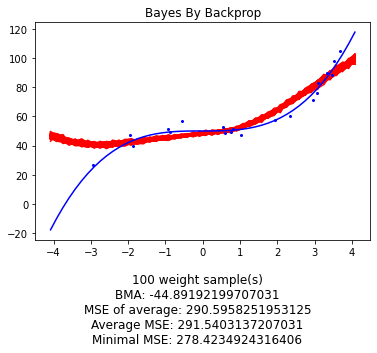

In [56]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
#prior = util.GaussianMixture(pi, sigma1, sigma2)
prior = torch.distributions.Normal(0, 1.0)

bbb_model = util.GaussWrapper(nn.Sequential(
    bbb.BBBLinear(1, 100, prior, prior, device, mc_sample=2, sampling="activations"),
    nn.ReLU(),
    bbb.BBBLinear(100, 1, prior, prior, device, mc_sample=2, sampling="activations")
), torch.tensor(3))
bbb_model.to(device)
optimizer = torch.optim.SGD(bbb_model.parameters(), lr=0.01)
def uncurried_nll_loss(output, target):
    mean, var = output
    return F.gaussian_nll_loss(mean, target, var)

for epoch in range(160):
    loss = bbb.run_bbb_epoch(bbb_model, optimizer, uncurried_nll_loss, trainloader, device)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input):
    bbb_model.eval()
    return [bbb_model(input) for _ in range(100)]
trainset.plot("Bayes By Backprop", eval_bbb)

Epoch 0: loss 351.7580261230469
Epoch 100: loss 5.5813775062561035
Final loss 4.597132205963135


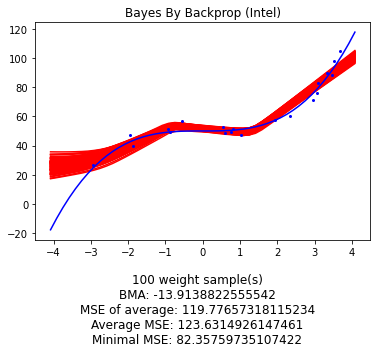

In [57]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

torch.manual_seed(42)

intel_model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
), torch.tensor(3))
dnn_to_bnn(intel_model, {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",
        "moped_enable": False,
        "moped_delta": 0.5,
})

optimizer = torch.optim.Adam(intel_model.parameters(), 0.01)
for epoch in range(160):
    intel_model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = intel_model(data)
        loss = get_kl_loss(intel_model) / batch_size + F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_bayes(input):
    intel_model.eval()
    return [intel_model(input) for _ in range(100)]
trainset.plot("Bayes By Backprop (Intel)", eval_bayes)